In [1]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as dt

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from raytracer_utils import readdump, read_rayfile
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = 6 #fig_width_pt*inches_per_pt  # width in inches
fig_height = 6 # fig_width*golden_mean*2      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 20,
          'text.fontsize': 16,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)

# --------------- Latex Plot Beautification --------------------------




/shared/users/asousa/software/python2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [27]:
binprefix = '../lib/raytracer/bin/'
# Constants:
R_E = 6371e3 # Radius of earth in meters
D2R = (np.pi/180.0)


# Initial timestep in seconds
dt0 = 1e-3;
# Maximum allowable timestep in seconds
dtmax = .1;
# Maximum time
tmax = 10;

# Which root of the appleton-hartree equation (2=whistler in the magnetosphere)
root = 2;
# Whether to use fixed steps (1) or adaptive timesteps (0).
# Fixed steps have NO way to recover if you pop outside the resonance
# cone, so adaptive is always recommended
fixedstep = 0;
# Error bound for adaptive timestepping
maxerr = 5e-4;
# Maximum number of timesteps (abort if reached)
maxsteps = 100000;
# Minimum altitude (abort if reached)
minalt = R_E;

# Input rays file
inputfile = 'testinputfile.txt';
# Output from the raytracer
outputfile = 'four_adjacent.txt';
# Model (1=ngo, 2=GCPM (SLOW!!), 3=interpolated, 4=scattered interpolated)
modelnum = 4;
# Output every "outputper" steps (reduces output file size)
outputper = 1; 

# Year and day of year 
yearday = 2001001;
# Milliseconds within a day
milliseconds_day = 0;
# Whether to use (1) or not use (0) the Tsyganenko magnetic field model Note
# that since the tsyganenko model returns /corrections/ to the geomagnetic
# field, is not mutually exclusive with IGRF, and in fact should probably be
# used with it!  
use_tsyganenko = 1;
# Whether to use the IGRF magnetic field model (1) or the dipole model (0)
use_igrf = 1;
# Dynamic solar wind pressure in nP, used by the Tsyganenko model
Pdyn = 4;
# Dst in nT, used by the Tsyganenko model
Dst = 0;
# IMF y component in nT, used by the Tsyganenko model
ByIMF = 0;
# IMF z component in nT, used by the Tsyganenko model
BzIMF = -5;
# Tsyganenko W parameters (see TS04_s/TS05 documentation!)
W = [0.132,    0.303,    0.083,    0.070,    0.211,    0.308 ]

if modelnum==1:
    # This is used to set up the parameters for the old plasmasphere model.
    # It is NOT used to set up rays for the new raytracer.
    configfile = 'newray.in'
elif modelnum==2:
    kp = 4.0
elif modelnum==3:
    interpfile='gcpm_kp4_2001001_L10_80x80x80_noderiv.txt'
elif modelnum==4:
    interpfile='gcpm_kp4_2001001_L10_random_5000_20000_0_200000_600000.txt'
    scattered_interp_window_scale=1.3;
    scattered_interp_order=2;
    scattered_interp_exact=0;
    scattered_interp_local_window_scale=2.5;


# Generate input coordinates in georgraphic lat, lon:
#inp_lats = np.arange(-90,90, step=10)
#inp_lons = np.arange(-180,180, step=20)
inp_lats = [30, 31]
inp_lons = [180, 181]
#inp_lons = [0, 90, 180, 270]
launch_alt = 1000e3 # meters

f = np.array([1000, 1050])
w = 2*np.pi*f;

lats, lons, ws = np.meshgrid(inp_lats, inp_lons, w)
lats = lats.flatten()
lons = lons.flatten()
ws   = ws.flatten()

alts = (R_E + launch_alt)*np.ones_like(lats)
flashtime = dt.datetime(2012, 3, 3, 12, 0, 0)

# Create spacepy coordinate structures
inp_coords = coord.Coords(zip(alts, lats, lons), 'GEO', 'sph',units=['m','deg','deg'])
inp_coords.ticks = Ticktock(np.tile(flashtime, len(inp_coords))) # add ticks

# Rotate to SM cartesian coordinates
inp_coords = inp_coords.convert('SM','car')
N = len(inp_coords)

# Write rays to the input file
f = open(inputfile,'w+')
for pos0, w0 in zip(inp_coords.data, ws):
    dir0 = pos0/np.linalg.norm(pos0)
    f.write('%g %g %g %g %g %g %g\n'%(pos0[0],pos0[1],pos0[2],dir0[0], dir0[1],dir0[2], w0))
    
f.close()



In [28]:
starttime = time.time()



# # initial position for each ray (in SM coordinates)
# launch_alt = R_E + 4000e3
# # dir0 = np.array([np.cos(D2R*inp_lats), np.zeros_like(inp_lats), np.sin(D2R*inp_lats)]).T
# dir0 = np.array([np.cos(theta)*np.cos(phi), np.cos(theta)*np.sin(phi), np.sin(theta)]).T
# pos0 = launch_alt*dir0



# # Write the rays to the input file
# f=open(inputfile,'w+')
# for ii in range(0,N):
#     f.write('%g %g %g %g %g %g %g\n'%(pos0[ii,0],pos0[ii,1],pos0[ii,2],dir0[ii,0], dir0[ii,1],dir0[ii,2], w))

# f.close()

cmd=['%sraytracer --outputper=%d --dt0=%g --dtmax=%g'%(binprefix, outputper, dt0, dtmax) +
     ' --tmax=%g --root=%d --fixedstep=%d --maxerr=%g'%(tmax, root, fixedstep, maxerr) +
     ' --maxsteps=%d --minalt=%d --inputraysfile=%s --outputfile=%s'%( maxsteps, minalt, inputfile, outputfile) +
     ' --modelnum=%d --yearday=%d --milliseconds_day=%d'%(modelnum, yearday, milliseconds_day) +
     ' --use_tsyganenko=%d --use_igrf=%d --tsyganenko_Pdyn=%g'%(use_tsyganenko, use_igrf, Pdyn) +
     ' --tsyganenko_Dst=%g --tsyganenko_ByIMF=%g --tsyganenko_BzIMF=%g'%( Dst, ByIMF, BzIMF ) +
     ' --tsyganenko_W1=%g --tsyganenko_W2=%g --tsyganenko_W3=%g'%(W[0], W[1], W[2]) +
     ' --tsyganenko_W4=%g --tsyganenko_W5=%g --tsyganenko_W6=%g'%(W[3], W[4], W[5])]

cmd = cmd[0]
# Append model-specific parameters to the command line
if  modelnum == 1:
    cmd += ' --ngo_configfile=%s'%configfile
elif modelnum == 2:
    cmd += ' --gcpm_kp=%g'%kp
elif modelnum == 3: 
    cmd += ' --interp_interpfile=%s'%interpfile
elif modelnum == 4:
    cmd += ' --interp_interpfile=%s'%interpfile
    cmd += ' --scattered_interp_window_scale=%g'%scattered_interp_window_scale
    cmd += ' --scattered_interp_order=%d'%scattered_interp_order
    cmd += ' --scattered_interp_exact=%d'%scattered_interp_exact
    cmd += ' --scattered_interp_local_window_scale=%g'%scattered_interp_local_window_scale

# print "Running: ", cmd
os.system(cmd)

stoptime = time.time()

print "Finished with raytracing"
print "Time elapsed: %d seconds"%(stoptime - starttime)



# ------------------------------------------------------------------------------
# Dump plasmasphere model
# ------------------------------------------------------------------------------
# Build dump command:
minx = -R_E*10;
maxx = R_E*10;
miny = -R_E*10;
maxy = R_E*10;
minz = 0;
maxz = 0;
nx = 200;
ny = 200;
nz = 1;
dumpout = 'dumpout.txt';


# % Build the command line.  We'll append it later with model-specific things
dump_cmd=['%sdumpmodel --minx=%0.24e --maxx=%0.24e --miny=%0.24e'%(binprefix, minx, maxx, miny) +
          ' --maxy=%0.24e --minz=%0.24e --maxz=%0.24e'%(maxy, minz, maxz) +
          ' --nx=%d --ny=%d --nz=%d --filename=%s'%(nx, ny, nz, dumpout) +
          ' --modelnum=%d --yearday=%d --milliseconds_day=%d'%(modelnum, yearday, milliseconds_day) +
          ' --use_tsyganenko=%d --use_igrf=%d --tsyganenko_Pdyn=%0.24e'%(use_tsyganenko, use_igrf, Pdyn) +
          ' --tsyganenko_Dst=%0.24e --tsyganenko_ByIMF=%0.24e --tsyganenko_BzIMF=%0.24e'%(Dst, ByIMF, BzIMF) +
          ' --tsyganenko_W1=%0.24e --tsyganenko_W2=%0.24e --tsyganenko_W3=%0.24e'%(W[0], W[1], W[2]) +
          ' --tsyganenko_W4=%0.24e --tsyganenko_W5=%0.24e --tsyganenko_W6=%0.24e '%(W[3],W[4], W[5])]
dump_cmd = dump_cmd[0]


# % Append model-specific parameters to the command line
if( modelnum == 1 ):
    dump_cmd += ' --ngo_configfile=%s'%configfile
elif( modelnum == 2 ):
    dump_cmd += ' --gcpm_kp=%0.24e'%kp
elif( modelnum == 3 ):
    dump_cmd += ' --interp_interpfile=%s'%interpfile
elif( modelnum == 4 ):
    dump_cmd += ' --interp_interpfile=%s'%interpfile
    dump_cmd += ' --scattered_interp_window_scale=%0.24e'%scattered_interp_window_scale
    dump_cmd += ' --scattered_interp_order=%d'%scattered_interp_order
    dump_cmd += ' --scattered_interp_exact=%d'%scattered_interp_exact
    dump_cmd += ' --scattered_interp_local_window_scale=%0.24e'%scattered_interp_local_window_scale

print '---------'
# print "Running: ", dump_cmd
# os.system(dump_cmd)

Finished with raytracing
Time elapsed: 130 seconds
---------


In [109]:
# Load rayfile:
rf = read_rayfile('rayout.txt')

rays = []
for r in rf:
    tmp_coords = coord.Coords(zip(r['pos'].x, r['pos'].y, r['pos'].z),'SM','car',units=['m','m','m'])
    tvec_datetime = [flashtime + dt.timedelta(seconds=s) for s in r['time']]
    tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
    tmp_coords.convert('GEO','car')
    
    rays.append(tmp_coords)


<IPython.core.display.Javascript object>


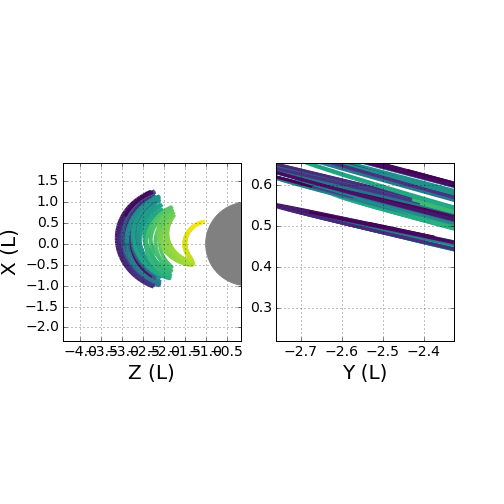

bark
bark
bark
bark
bark
bark
bark
bark


In [29]:
from matplotlib import collections  as mc


D2R = np.pi/180.

# Load rayfile:
rf = read_rayfile('four_adjacent.txt')

# Convert to geographic coordinates for plotting:
rays = []
for r in rf:
    tmp_coords = coord.Coords(zip(r['pos'].x, r['pos'].y, r['pos'].z),'SM','car',units=['m','m','m'])
    tvec_datetime = [flashtime + dt.timedelta(seconds=s) for s in r['time']]
    tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
    tmp_coords.convert('MAG','car')
    tmp_coords.sim_time = r['time']

    rays.append(tmp_coords)

# Initialize plot
fig, ax = plt.subplots(1,2)
[a.set_aspect("equal") for a in ax]

# Plot the earth
earth0 = plt.Circle((0,0),1,color='0.5',alpha=1, zorder=100)
earth1 = plt.Circle((0,0),1,color='0.5',alpha=1, zorder=100)
ax[0].add_patch(earth0)                    # The earth (round)
ax[1].add_patch(earth1)
# Plot rays:
for r in rays:
    print "bark"
    points = np.array([r.x/R_E, r.z/R_E]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    C = plt.cm.viridis(1 - r.sim_time/np.max(r.sim_time))
    lc = mc.LineCollection(segments, alpha=1, colors=C, linewidth=3)
    ax[0].add_collection(lc)

    points = np.array([r.x/R_E, r.y/R_E]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    C = plt.cm.viridis(1 - r.sim_time/np.max(r.sim_time))
    lc = mc.LineCollection(segments, alpha=1, colors=C, linewidth=3)
    ax[1].add_collection(lc)
    
ax[0].set_ylabel('X (L)')
ax[0].set_xlabel('Z (L)')
ax[0].set_xlim([-6, 6])
ax[0].set_ylim([-6, 6])
ax[0].grid()

ax[1].set_xlabel('Y (L)')
ax[1].set_xlim([-6, 6])
ax[1].set_ylim([-6, 6])
ax[1].grid()

# plt.savefig('model4.png')


<IPython.core.display.Javascript object>


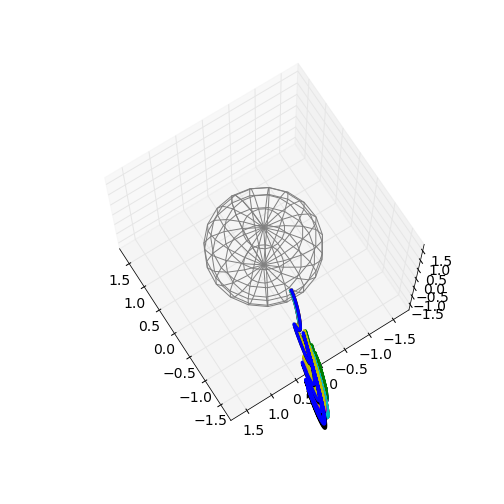

(-4, 4)

In [30]:
# Load rayfile:
rf = read_rayfile('four_adjacent.txt')

psize = 4
# Convert to geographic coordinates for plotting:
rays = []
for r in rf:
    tmp_coords = coord.Coords(zip(r['pos'].x, r['pos'].y, r['pos'].z),'SM','car',units=['m','m','m'])
    tvec_datetime = [flashtime + dt.timedelta(seconds=s) for s in r['time']]
    tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
    tmp_coords.convert('MAG','car')
    tmp_coords.sim_time = r['time']

    rays.append(tmp_coords)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect("equal")

# Plot the earth
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x=np.cos(u)*np.sin(v)
y=np.sin(u)*np.sin(v)
z=np.cos(v)
ax.plot_wireframe(x, y, z, color="grey")


# Plot rays:
for r in rays:
    ax.plot(r.x/R_E, r.y/R_E, r.z/R_E, linewidth=3)

ax.set_xlim([-psize, psize])
ax.set_ylim([-psize, psize])
ax.set_zlim([-psize, psize])



(-5, 5)

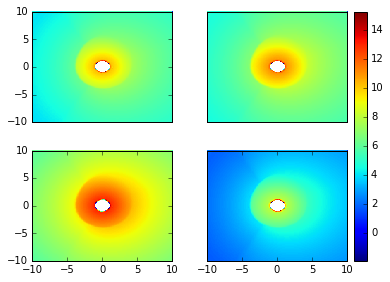

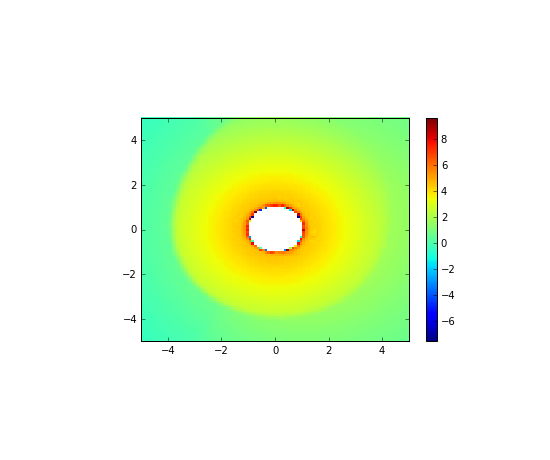

In [53]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
d = readdump('dumpout.txt')
R_E = 6371e3;


nspecies = np.shape(d['Ns'])[0]

# _, xgrid, ygrid, zgrid = np.meshgrid(np.arange(0,nspecies),d['x'],d['y'],d['z'])

# Initialize plot
fig, ax = plt.subplots(2,2)
ax = ax.flatten()
for ii in range(nspecies):
    img = np.squeeze(np.log10(d['Ns'][ii,:,:,:])).T
    p = ax[ii].pcolorfast(d['x']/R_E,d['y']/R_E,img)
    
fig.tight_layout()
cb = fig.colorbar(p,ax=ax.ravel().tolist(),pad=0.02)

ax[0].set_xticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[3].set_yticks([])

fig, ax = plt.subplots()
img = np.squeeze(np.log10(np.sum(d['Ns'],axis=0)*1e-6)).T
p = ax.pcolorfast(d['x']/R_E,d['y']/R_E,img)
fig.colorbar(p)
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])



In [55]:
# inp_lats = np.arange(0, 90, step=10)

# # initial position for each ray (in SM coordinates)
# launch_alt = R_E + 4000e3
# dir0 = np.array([np.cos(D2R*inp_lats), np.zeros_like(inp_lats), np.sin(D2R*inp_lats)]).T
# print np.shape(dir0)
# print dir0

(9, 3)
[[ 1.          0.          0.        ]
 [ 0.98480775  0.          0.17364818]
 [ 0.93969262  0.          0.34202014]
 [ 0.8660254   0.          0.5       ]
 [ 0.76604444  0.          0.64278761]
 [ 0.64278761  0.          0.76604444]
 [ 0.5         0.          0.8660254 ]
 [ 0.34202014  0.          0.93969262]
 [ 0.17364818  0.          0.98480775]]


In [121]:
# Build GCPM grids (for the interpolating model, I think)

minx = -10*R_E
maxx =  10*R_E
miny = -10*R_E
maxy =  10*R_E
minz = -10*R_E
maxz =  10*R_E
nx = 500
ny = 500
nz = 500
compder = 0
gcpm_kp = 0
yearday = 2015001
milliseconds_day = 0
gcpm_filename = 'gcpm_test.txt'

gcpm_cmd = ['%sgcpm_dens_model_buildgrid --minx=%0.24e --maxx=%0.24e'%(binprefix, minx, maxx) +
            ' --miny=%0.24e --maxy=%0.24e --minz=%0.24e --maxz=%0.24e'%(miny, maxy, minz, maxz) +
            ' --nx=%d --ny=%d --nz=%d'%(nx, ny, nz) +
            ' --compder=%d --gcpm_kp=%f --yearday=%d milliseconds_day=%d'%(compder, gcpm_kp, yearday, milliseconds_day) +
            ' --filename=%s'%(gcpm_filename)]

gcpm_cmd = gcpm_cmd[0]
print gcpm_cmd

os.system(gcpm_cmd)

../bin/gcpm_dens_model_buildgrid --minx=-6.371000000000000000000000e+07 --maxx=6.371000000000000000000000e+07 --miny=-6.371000000000000000000000e+07 --maxy=6.371000000000000000000000e+07 --minz=-6.371000000000000000000000e+07 --maxz=6.371000000000000000000000e+07 --nx=500 --ny=500 --nz=500 --compder=0 --gcpm_kp=0.000000 --yearday=2015001 milliseconds_day=0 --filename=gcpm_test.txt


0

In [40]:
r['time'].iloc[-1]

30.014286053425568

In [28]:
filename='../bin/dumpout.txt'
def readdump(filename):
    ''' Reads the dump files from Forests raytracer
        % x - vector of x coordinates in meters
        % y - vector of y coordinates in meters
        % z - vector of z coordinates in meters
        % 
        % qs - array(ispecies, ix, iy, iz) of charges for each species
        % Ns - array(ispecies, ix, iy, iz) of number densities in m^-3 
        % Ms - array(ispecies, ix, iy, iz) of masses in kg
        % nus - array(ispecies, ix, iy, iz) of collision frequencies in s^-1
        % B0 - array(icomponent, ix,iy, iz) containing the background magnetic
    '''
    out = dict()
    
    f = open(filename,'r')
    line = f.readline().split()
    nspec = int(line[0])
    nx = int(line[1])
    ny = int(line[2])
    nz = int(line[3])
    
    line = f.readline().split()
    minx = float(line[0])
    maxx = float(line[1])
    miny = float(line[2])
    maxy = float(line[3])
    minz = float(line[4])
    maxz = float(line[5])
    
#     print maxz
    
    dat = [float(x) for x in f.readlines()]
#     print np.shape(dat)
#     print dat[0:10]
    dat = np.reshape(dat,[nspec*4 + 3, nx, ny, nz],order='f')
#     print np.shape(dat)
    
    out['qs'] = dat[0*nspec:(1*nspec),:,:,:]
    out['Ns'] = dat[1*nspec:(2*nspec),:,:,:]
    out['Ms'] = dat[2*nspec:(3*nspec),:,:,:]
    out['nus']= dat[3*nspec:(4*nspec),:,:,:]
    out['B0'] = dat[4*nspec:-1,:,:,:]
    
    out['x'] = np.linspace(minx, maxx, nx)
    out['y'] = np.linspace(miny, maxy, ny)
    out['z'] = np.linspace(minz, maxz, nz)
    
    return out
    
# dump = readdump(filename)
# print dump['y']/R_E


In [90]:
import pandas as pd

def read_rayfile(rayfile):
    ''' Load output from Forest's raytracer'''
    x = pd.read_csv(rayfile,delim_whitespace=True, header=None)
    # % fields: raynum, stopcond, time, pos(3), vprel(3), vgrel(3), n(3),
    # % B0(3), Nspec, qs(Nspec), ms(Nspec), Ns(Nspec), nus(Nspec)

    raynums = np.unique(x[0])
    numrays = len(raynums)

    out = []
    for ii in range(numrays):
        tmp = x[x[0]==raynums[ii]]
        #data = pd.DataFrame(columns=['raynum','time','pos','vprel','vgrel','n','B0','qs','ms','Ns','nus'])
        data = dict()
        data['time'] = tmp[2]
        data['pos'] = tmp.loc[:,3:5]
        data['pos'].columns=['x','y','z']
        data['vprel'] = tmp.loc[:,6:8]
        data['vprel'].columns=['x','y','z']
        data['vgrel'] = tmp.loc[:,9:11]
        data['vgrel'].columns=['x','y','z']
        data['n'] = tmp.loc[:,12:14]
        data['n'].columns=['x','y','z']
        data['B0'] = tmp.loc[:,15:17]
        data['B0'].columns=['x','y','z']
        
        

        data['w'] = tmp.iloc[0,18]       # Frequency
        data['Nspec'] = tmp.iloc[0,19]   # Number of species
        data['stopcond'] = tmp.iloc[0,1] # Stop condition
        data['qs'] =  tmp.loc[:,20 + 0*data['Nspec']:20 + 1*data['Nspec'] - 1]
        data['ms'] =  tmp.loc[:,20 + 1*data['Nspec']:20 + 2*data['Nspec'] - 1]
        data['Ns'] =  tmp.loc[:,20 + 2*data['Nspec']:20 + 3*data['Nspec'] - 1]
        data['nus']=  tmp.loc[:,20 + 3*data['Nspec']:20 + 4*data['Nspec'] - 1]

        out.append(data)
    return out

# rf = read_rayfile('bin/testoutputfile.txt')
